In [1]:
# Imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle, Wedge, Polygon
import math
import os
import time
import itertools

import joblib

import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection

from sklearn.metrics import pairwise_distances

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'monospace'
#plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

%matplotlib notebook

plt.rcParams['figure.figsize'] = [7, 7]

import torch
import torch.nn
import torch.utils.data
import torchvision

In [2]:
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 8)
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 8)
        self.fc4 = torch.nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [3]:
def calcRegion(network, data):
    network.zero_grad()
    output = network(data)
    output = output[:, 1] - output[:, 0]
    g = torch.autograd.grad(torch.sum(output), data)[0].data
    
    weights = np.array(g.tolist())
    
    inputs = np.array(data.tolist())
    result = np.sum(np.multiply(weights,inputs), axis=1)
    biases = np.array(output.tolist()) - result
    
    regions = np.concatenate((weights, biases[:, None]), axis=1)
    
    return regions

def getRegions(network, dataLoader):
    regions = np.array([]).reshape(0, 3)
    for batch_idx, (data, target) in enumerate(dataLoader):
        data.requires_grad_()
        region = calcRegion(network, data)
        regions = np.concatenate((regions, region), axis=0)
        
    return np.array(regions)

In [4]:
def calcZs(network, bounds=2, res=201):
    As = []
    bs = []
    params = list(network.parameters())
    for i in range(0, len(params), 2):
        As.append(params[i].data.numpy())
        bs.append(params[i+1].data.numpy())
    
    
    x = np.linspace(-bounds, bounds, res)
    y = np.copy(x)

    X, Y = np.meshgrid(x, y)
    origShape = X.shape

    X = np.reshape(X, -1)
    Y = np.reshape(Y, -1)

    inputVal = np.vstack((X, Y))

    dataset = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(inputVal).T,torch.Tensor(inputVal).T), batch_size=10000)
    
    regions = getRegions(network, dataset)
    regions = np.unique(np.around(regions, decimals=2), axis=0)
    
    outs = []
    outs.append((np.matmul(As[0], inputVal).T + bs[0]).T)
    for i in range(1, len(As)):
        outs.append((np.matmul(As[i], np.maximum(outs[i-1], 0)).T + bs[i]).T)

    X = np.reshape(X, origShape)
    Y = np.reshape(Y, origShape)
    
    return X, Y, outs, regions

In [5]:
def plotNodeColored(X, Y, val, color, ax):
    Z = np.reshape(val, X.shape)
    ax.contour(X, Y, Z, [0], colors=color);
        
def plotLayerUncolored(X, Y, vals, alpha, ax):
    for i in range(vals.shape[0]):
        Z = np.reshape(vals[i, :], X.shape)
        ax.contour(X, Y, Z, [0], colors='k', alpha=alpha);
        
def plotLayersUncolored(X, Y, valList, ax):    
    alpha = 0.25
    
    for val in valList[::-1]:
        plotLayerUncolored(X, Y, val, alpha, ax)

In [6]:
def plotPolytopeRegions(X, Y, f, g, ax):
    origShape = X.shape

    X = np.reshape(X, -1)[:, None]
    Y = np.reshape(Y, -1)[:, None]

    inputVal = np.concatenate((X, Y), axis=1)

    fIndices = f.calcIndex(inputVal)
    gIndices = g.calcIndex(inputVal)

    combos = set()
    for i in range(fIndices.shape[0]):
        combos.add((fIndices[i], gIndices[i]))

    lRegions = []
    for elem in combos:
        lRegions.append(f.monomials[elem[0], :] - g.monomials[elem[1], :])
    lRegions = np.unique(lRegions, axis=0)
    
    ax.scatter(lRegions[:, 0], lRegions[:, 1], lRegions[:, 2])
    ax.set_title('Linear Regions\n{} regions'.format(lRegions.shape[0]))

In [7]:
accuracies = np.load('accuracies.npy')
indices = np.load('indices.npy')

Time taken to 2000 is 6.3758385181427
Time taken to 1999 is 12.320414304733276
Time taken to 1998 is 19.163408756256104
Time taken to 1997 is 26.167405128479004
Time taken to 1996 is 33.03740859031677
Time taken to 1995 is 39.29332756996155
Time taken to 1994 is 45.403560161590576
Time taken to 1993 is 50.90867233276367
Time taken to 1992 is 55.278263568878174
Time taken to 1991 is 61.24204421043396
Time taken to 1990 is 67.28514766693115
Time taken to 1989 is 73.3628716468811
Time taken to 1988 is 79.36661148071289
Time taken to 1987 is 84.47372055053711
Time taken to 1986 is 90.92060017585754
Time taken to 1985 is 97.20840072631836
Time taken to 1984 is 102.07667231559753
Time taken to 1983 is 107.40539979934692
Time taken to 1982 is 113.42572069168091
Time taken to 1981 is 119.43756079673767
Time taken to 1980 is 125.63536882400513
Time taken to 1979 is 131.63704991340637
Time taken to 1978 is 137.78474116325378
Time taken to 1977 is 143.82140254974365
Time taken to 1976 is 149.8842

Time taken to 1796 is 1036.4943652153015
Time taken to 1795 is 1040.8276798725128
Time taken to 1794 is 1045.158313035965
Time taken to 1793 is 1051.0950102806091
Time taken to 1792 is 1057.071268081665
Time taken to 1791 is 1063.0602519512177
Time taken to 1790 is 1068.9039976596832
Time taken to 1789 is 1073.2109971046448
Time taken to 1788 is 1077.514316558838
Time taken to 1787 is 1081.8374252319336
Time taken to 1786 is 1086.1474418640137
Time taken to 1785 is 1090.4957451820374
Time taken to 1784 is 1094.8564167022705
Time taken to 1783 is 1099.7050728797913
Time taken to 1782 is 1104.0811052322388
Time taken to 1781 is 1108.422670841217
Time taken to 1780 is 1112.7474026679993
Time taken to 1779 is 1117.1066846847534
Time taken to 1778 is 1121.455528974533
Time taken to 1777 is 1125.7925479412079
Time taken to 1776 is 1130.137229681015
Time taken to 1775 is 1134.4950363636017
Time taken to 1774 is 1138.8468050956726
Time taken to 1773 is 1143.193103313446
Time taken to 1772 is 1

Time taken to 1594 is 2031.404765844345
Time taken to 1593 is 2035.7359993457794
Time taken to 1592 is 2040.1164844036102
Time taken to 1591 is 2044.4676203727722
Time taken to 1590 is 2048.776124238968
Time taken to 1589 is 2053.1130390167236
Time taken to 1588 is 2057.468775987625
Time taken to 1587 is 2061.8035278320312
Time taken to 1586 is 2066.1508049964905
Time taken to 1585 is 2070.4677045345306
Time taken to 1584 is 2074.8187024593353
Time taken to 1583 is 2079.1370108127594
Time taken to 1582 is 2083.478968858719
Time taken to 1581 is 2087.816786289215
Time taken to 1580 is 2092.1499869823456
Time taken to 1579 is 2096.440866470337
Time taken to 1578 is 2100.842890024185
Time taken to 1577 is 2105.1654529571533
Time taken to 1576 is 2109.531839132309
Time taken to 1575 is 2113.8914000988007
Time taken to 1574 is 2118.222524881363
Time taken to 1573 is 2122.577945947647
Time taken to 1572 is 2126.9067974090576
Time taken to 1571 is 2131.2598497867584
Time taken to 1570 is 2135

Time taken to 1391 is 3054.531358718872
Time taken to 1390 is 3058.857189178467
Time taken to 1389 is 3063.2315514087677
Time taken to 1388 is 3067.5135033130646
Time taken to 1387 is 3071.838398694992
Time taken to 1386 is 3077.6036746501923
Time taken to 1385 is 3083.603011608124
Time taken to 1384 is 3089.636067867279
Time taken to 1383 is 3094.0460953712463
Time taken to 1382 is 3098.3578774929047
Time taken to 1381 is 3102.7794892787933
Time taken to 1380 is 3107.1238651275635
Time taken to 1379 is 3111.4424064159393
Time taken to 1378 is 3115.7286343574524
Time taken to 1377 is 3120.074859857559
Time taken to 1376 is 3124.431657552719
Time taken to 1375 is 3128.7802975177765
Time taken to 1374 is 3133.100677728653
Time taken to 1373 is 3137.4082844257355
Time taken to 1372 is 3143.3515741825104
Time taken to 1371 is 3149.27893948555
Time taken to 1370 is 3154.304775953293
Time taken to 1369 is 3158.6143712997437
Time taken to 1368 is 3162.9257414340973
Time taken to 1367 is 3167.

Time taken to 1188 is 4159.241393566132
Time taken to 1187 is 4164.048182010651
Time taken to 1186 is 4168.362291574478
Time taken to 1185 is 4172.672735452652
Time taken to 1184 is 4177.000883102417
Time taken to 1183 is 4181.325575828552
Time taken to 1182 is 4185.663922786713
Time taken to 1181 is 4189.992107629776
Time taken to 1180 is 4194.301253080368
Time taken to 1179 is 4198.576401948929
Time taken to 1178 is 4202.87610244751
Time taken to 1177 is 4207.198398113251
Time taken to 1176 is 4211.520714998245
Time taken to 1175 is 4215.853912591934
Time taken to 1174 is 4220.153029680252
Time taken to 1173 is 4224.464627504349
Time taken to 1172 is 4228.761657953262
Time taken to 1171 is 4233.076875925064
Time taken to 1170 is 4237.391354799271
Time taken to 1169 is 4241.708540916443
Time taken to 1168 is 4245.990072011948
Time taken to 1167 is 4250.326352596283
Time taken to 1166 is 4254.661908149719
Time taken to 1165 is 4258.986348867416
Time taken to 1164 is 4263.3111119270325


Time taken to 982 is 5152.228849887848
Time taken to 981 is 5156.599798202515
Time taken to 980 is 5160.96634888649
Time taken to 979 is 5166.928578853607
Time taken to 978 is 5172.8897540569305
Time taken to 977 is 5178.896301269531
Time taken to 976 is 5184.880226135254
Time taken to 975 is 5190.846301794052
Time taken to 974 is 5196.811463356018
Time taken to 973 is 5202.502752065659
Time taken to 972 is 5206.834696054459
Time taken to 971 is 5211.118261814117
Time taken to 970 is 5215.467254400253
Time taken to 969 is 5219.878099441528
Time taken to 968 is 5224.233481884003
Time taken to 967 is 5228.565394639969
Time taken to 966 is 5232.937360286713
Time taken to 965 is 5237.267649888992
Time taken to 964 is 5241.593225717545
Time taken to 963 is 5245.926557779312
Time taken to 962 is 5250.253268480301
Time taken to 961 is 5254.557604551315
Time taken to 960 is 5258.91402888298
Time taken to 959 is 5264.65346288681
Time taken to 958 is 5270.7211561203
Time taken to 957 is 5276.715

Time taken to 771 is 6199.480536937714
Time taken to 770 is 6205.513599872589
Time taken to 769 is 6211.486658811569
Time taken to 768 is 6217.50658249855
Time taken to 767 is 6223.516757011414
Time taken to 766 is 6228.475536584854
Time taken to 765 is 6232.832134962082
Time taken to 764 is 6237.161987066269
Time taken to 763 is 6241.502354383469
Time taken to 762 is 6245.823538541794
Time taken to 761 is 6251.704513311386
Time taken to 760 is 6257.646018266678
Time taken to 759 is 6263.593310594559
Time taken to 758 is 6269.54604268074
Time taken to 757 is 6275.551645040512
Time taken to 756 is 6281.532367706299
Time taken to 755 is 6287.486173629761
Time taken to 754 is 6293.511031627655
Time taken to 753 is 6299.532880306244
Time taken to 752 is 6305.580573797226
Time taken to 751 is 6311.614582538605
Time taken to 750 is 6316.473886728287
Time taken to 749 is 6320.758113384247
Time taken to 748 is 6325.109434127808
Time taken to 747 is 6329.439684867859
Time taken to 746 is 6333.8

Time taken to 560 is 7374.326984405518
Time taken to 559 is 7378.652168750763
Time taken to 558 is 7383.028672456741
Time taken to 557 is 7387.395353317261
Time taken to 556 is 7392.811541318893
Time taken to 555 is 7397.145535945892
Time taken to 554 is 7401.474159002304
Time taken to 553 is 7405.845241308212
Time taken to 552 is 7410.195411205292
Time taken to 551 is 7414.54440164566
Time taken to 550 is 7418.864527463913
Time taken to 549 is 7423.252425909042
Time taken to 548 is 7427.570636987686
Time taken to 547 is 7431.901883840561
Time taken to 546 is 7436.267760276794
Time taken to 545 is 7440.634248018265
Time taken to 544 is 7444.941672801971
Time taken to 543 is 7449.284718751907
Time taken to 542 is 7453.629880666733
Time taken to 541 is 7457.9813351631165
Time taken to 540 is 7462.291642665863
Time taken to 539 is 7466.631616353989
Time taken to 538 is 7470.961483955383
Time taken to 537 is 7475.289591550827
Time taken to 536 is 7479.620964765549
Time taken to 535 is 7483

Time taken to 349 is 8332.917469024658
Time taken to 348 is 8337.25259923935
Time taken to 347 is 8341.563133239746
Time taken to 346 is 8347.480407238007
Time taken to 345 is 8353.390037536621
Time taken to 344 is 8359.296630382538
Time taken to 343 is 8365.201206684113
Time taken to 342 is 8371.107829093933
Time taken to 341 is 8376.993287086487
Time taken to 340 is 8383.010489463806
Time taken to 339 is 8387.916872501373
Time taken to 338 is 8393.834404706955
Time taken to 337 is 8399.778436422348
Time taken to 336 is 8405.700875043869
Time taken to 335 is 8411.59749174118
Time taken to 334 is 8417.497662782669
Time taken to 333 is 8423.397571086884
Time taken to 332 is 8429.292816400528
Time taken to 331 is 8435.180034399033
Time taken to 330 is 8440.380254268646
Time taken to 329 is 8444.63689160347
Time taken to 328 is 8448.917475700378
Time taken to 327 is 8453.213089704514
Time taken to 326 is 8457.51437330246
Time taken to 325 is 8461.824236631393
Time taken to 324 is 8466.115

Time taken to 137 is 9368.21957540512
Time taken to 136 is 9372.498875617981
Time taken to 135 is 9376.762888908386
Time taken to 134 is 9381.052005052567
Time taken to 133 is 9385.313008069992
Time taken to 132 is 9389.601510047913
Time taken to 131 is 9395.574257612228
Time taken to 130 is 9401.543484926224
Time taken to 129 is 9407.446631908417
Time taken to 128 is 9413.386121749878
Time taken to 127 is 9419.337752103806
Time taken to 126 is 9424.865275144577
Time taken to 125 is 9429.127442359924
Time taken to 124 is 9433.46591258049
Time taken to 123 is 9437.762107372284
Time taken to 122 is 9442.010132789612
Time taken to 121 is 9446.300677537918
Time taken to 120 is 9450.58833026886
Time taken to 119 is 9454.854315757751
Time taken to 118 is 9459.141082286835
Time taken to 117 is 9463.574309825897
Time taken to 116 is 9467.864727973938
Time taken to 115 is 9472.133499860764
Time taken to 114 is 9476.423410892487
Time taken to 113 is 9480.73554968834
Time taken to 112 is 9486.557

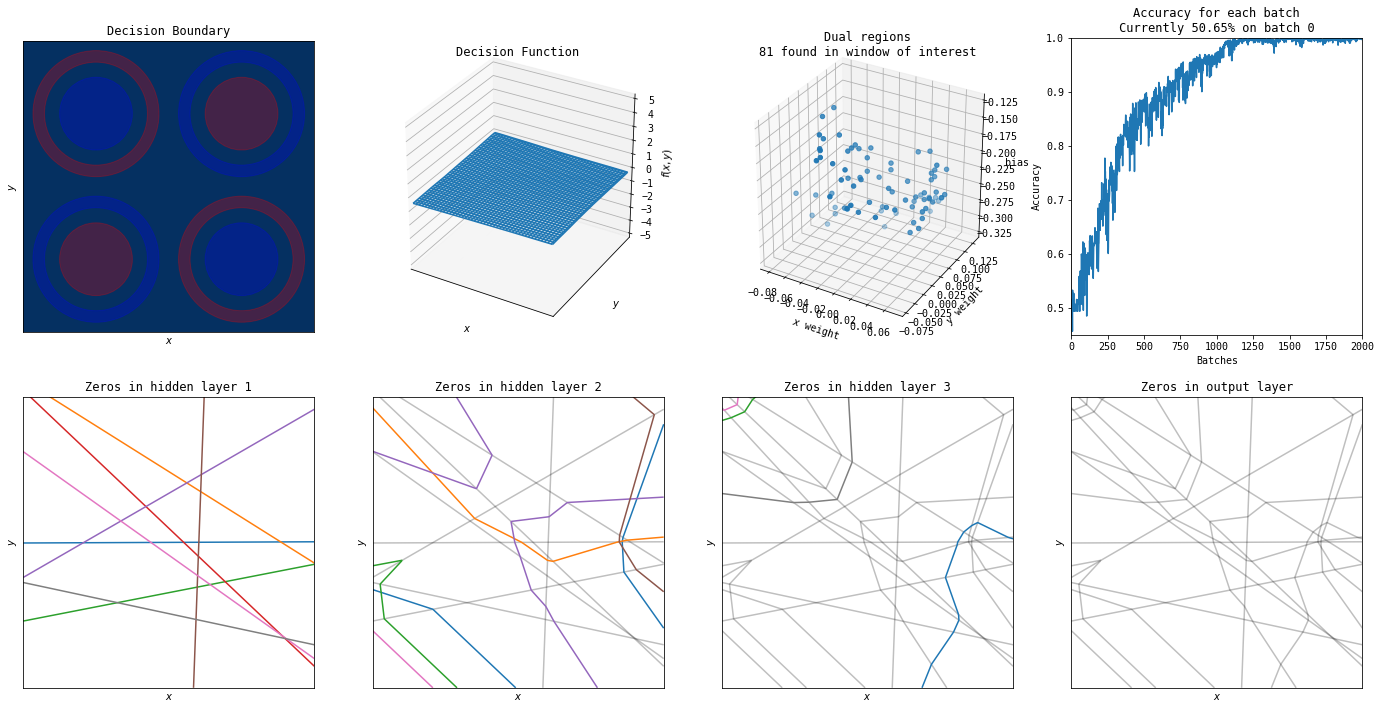

In [8]:
fig = plt.figure(figsize=(24, 12))

axDecision=fig.add_subplot(241)
axWireframe=fig.add_subplot(242, projection='3d')
axRegions=fig.add_subplot(243, projection='3d')
axAccuracies=fig.add_subplot(244)

axFirst = fig.add_subplot(245)
axSecond = fig.add_subplot(246)
axThird = fig.add_subplot(247)
axFourth = fig.add_subplot(248)

axPolytopes = [axFirst, axSecond, axThird, axFourth]

# Get rid of gray
colors = list(matplotlib.colors.TABLEAU_COLORS.keys())

r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(3*r1**2)

start = time.time()
for i in indices[2000::-1]:
    
    network = torch.load('trainedNets/network{:09d}.pt'.format(i))
    X, Y, outs, regions = calcZs(network, res=401)

    for ax in [axDecision, axFirst, axSecond, axThird, axFourth]:
        ax.clear()
        ax.set_xlim([-2, 2])
        ax.set_ylim([-2, 2])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        
    axWireframe.clear()
    axWireframe.set_xlim([-2, 2])
    axWireframe.set_ylim([-2, 2])
    axWireframe.set_xticks([])
    axWireframe.set_yticks([])
    #axWireframe.set_zticks([])
    axWireframe.set_title('Decision Function')
    axWireframe.set_xlabel('$x$')
    axWireframe.set_ylabel('$y$')
    axWireframe.set_zlabel('$f(x, y)$')
    axWireframe.set_zlim([-5.1, 5.1])
    axWireframe.set_zticks(range(-5, 6))
    
    axRegions.clear()
    axRegions.scatter(regions[:, 0], regions[:, 1], regions[:, 2])
    axRegions.set_title('Dual regions\n{} found in window of interest'.format(regions.shape[0]))
    axRegions.set_xlabel('$x$ weight')
    axRegions.set_ylabel('$y$ weight')
    axRegions.set_zlabel('bias')
    
    # Accuracy
    axAccuracies.clear()
    axAccuracies.plot(accuracies)
    axAccuracies.set_xlabel('Batches')
    axAccuracies.set_ylabel('Accuracy')
    axAccuracies.set_ylim([0.45, 1.0])
    axAccuracies.set_xlim([0, indices[2000]])
    axAccuracies.plot([i, i], [0, 100], 'k', alpha=0.5)
    axAccuracies.set_title('Accuracy for each batch\nCurrently {:.2f}% on batch {}'.format(100*accuracies[i], i))
    
    output = outs[-1][1] - outs[-1][0]
    output = output.reshape(X.shape)

    # Raw outputs
    axDecision.contourf(X, Y, output, vmin=-0.001, vmax=0.001,cmap='RdBu_r')
    axDecision.set_title('Decision Boundary')
    
    for point in itertools.product([1, -1], repeat=2):
        if point[0]*point[1] > 0:
            color1 = 'r'
            color2 = 'b'
        else:
            color1 = 'b'
            color2 = 'r'
        
        circle = Circle(point, 0.5, color=color1, alpha=0.25)
        annulus = Wedge(point, r3, 0, 360, width=r3-r2, color=color2, alpha=0.25)
        axDecision.add_artist(circle)
        axDecision.add_artist(annulus)
    
    # Wireframe
    axWireframe.plot_wireframe(X, Y, output)
    
    # Polytope construction
    for k in range(3):
        if k > 0:
            plotLayersUncolored(X, Y, outs[:k], axPolytopes[k])
        for j in range(len(outs[k])):
            plotNodeColored(X, Y, outs[k][j], colors[j], axPolytopes[k])
        axPolytopes[k].set_title('Zeros in hidden layer {}'.format(k+1))
        
    plotLayersUncolored(X, Y, outs[:-1], axPolytopes[-1])
    plotNodeColored(X, Y, output, colors[0], axPolytopes[-1])
    axPolytopes[-1].set_title('Zeros in output layer')

    fig.show()
    fig.canvas.draw()

    fig.savefig('circlesTraining/{:09d}.png'.format(i), bbox_inches='tight')

    time.sleep(1)
    
    print('Time taken to {} is {}'.format(i, time.time()-start))

In [9]:
os.system('ffmpeg -r 5 -i circlesTraining/%09d.png -r 10 circlesTraining.mp4')

0